In [1]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from binance.client import Client
client = Client()

from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

In [2]:
startDate = '2022-01-01 00:00:00'
testDate  = '2024-06-01 00:00:00'
r = client.get_historical_klines('BTCUSDT','1h',startDate)

In [3]:
df = pd.DataFrame(r)
colnames = ['openTime','openPrice','highPrice','lowPrice','closePrice','volume','closeTime','quoteAssetVolume','NumberOfTrades','TakerBaseVolume','TakerQuoteVolume','Ignore']
df.columns = colnames
df['closeTime'] = pd.to_datetime(df['closeTime'], unit='ms')
df = df.astype({'closePrice':'float','openPrice':'float','highPrice':'float','lowPrice':'float','volume':'float'})
df['return'] = df['closePrice'].pct_change()
df['return_next'] = df['return'].shift(-1).fillna(0)
df['predict'] = 1
df.set_index("closeTime", inplace= True)
df.head(2)

,openTime,openPrice,highPrice,lowPrice,closePrice,volume,quoteAssetVolume,NumberOfTrades,TakerBaseVolume,TakerQuoteVolume,Ignore,return,return_next,predict
closeTime,,,,,,,,,,,,,,
2022-01-01 00:59:59.999,1640995200000,46216.93,46731.39,46208.37,46656.13,1503.33095,69879986.39049930,38608,806.06536000,37462156.91764400,0,NaN,0.002615,1
2022-01-01 01:59:59.999,1640998800000,46656.14,46949.99,46574.06,46778.14,943.81539,44127148.11760220,31872,491.18067000,22963272.85537420,0,0.002615,0.000719,1


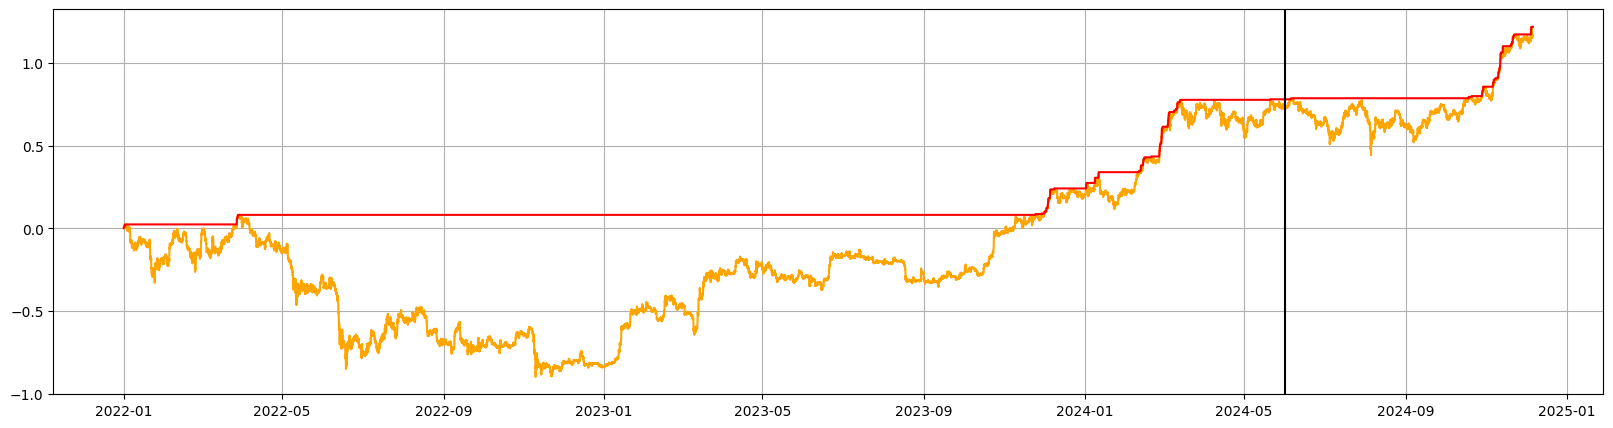

In [4]:
def func_plot(df):
  df['pnl'] = df['return_next'] * df['predict']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  plt.figure(figsize=(20,5))
  plt.plot(df['pnl_cumsum'],color='orange')
  plt.plot(df['pnl_cumsum_max'],color='red')
  plt.axvline(x = pd.to_datetime(testDate), color='black')
  plt.grid()
  plt.show()

func_plot(df)

In [5]:
def func_model_performance(df):
  train = df[(df.index<testDate)].reindex()
  test = df[(df.index>=testDate)].reindex()

  pnl_train = round(train['pnl'].sum(),6)
  pnl_test = round(test['pnl'].sum(),6)

  mdd_train = round(train['pnl_dd'].max(),6)
  mdd_test = round(test['pnl_dd'].max(),6)

  sharpe_train = round(pnl_train/mdd_train,6)
  sharpe_test = round(pnl_test/mdd_test,6)

  print('            train     test')
  print('PNL      : {0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
  print('MDD      : {0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
  print('Sharpe      : {0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
  return sharpe_train

In [6]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)

    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.

    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/

    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal

        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
            Histogram = MA

In [7]:
df.ta(kind='MACD',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
closeTime,,,
2022-01-01 00:59:59.999,NaN,NaN,NaN
2022-01-01 01:59:59.999,NaN,NaN,NaN
2022-01-01 02:59:59.999,NaN,NaN,NaN
2022-01-01 03:59:59.999,NaN,NaN,NaN
2022-01-01 04:59:59.999,NaN,NaN,NaN
...,...,...,...
2024-12-06 06:59:59.999,-616.233717,-243.618517,-372.615200
2024-12-06 07:59:59.999,-588.380998,-172.612639,-415.768359
2024-12-06 08:59:59.999,-543.353814,-102.068363,-441.285450


In [8]:
df.dtypes

openTime              int64
openPrice           float64
highPrice           float64
lowPrice            float64
closePrice          float64
volume              float64
quoteAssetVolume     object
NumberOfTrades        int64
TakerBaseVolume      object
TakerQuoteVolume     object
Ignore               object
return              float64
return_next         float64
predict               int64
pnl                 float64
pnl_cumsum          float64
pnl_cumsum_max      float64
pnl_dd              float64
MACD_12_26_9        float64
MACDh_12_26_9       float64
MACDs_12_26_9       float64
dtype: object

In [9]:
columns_to_convert = ['quoteAssetVolume', 'TakerBaseVolume', 'TakerQuoteVolume', 'Ignore']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [10]:
def func_features(df):
    for length in [6, 12, 16, 20, 25, 30, 50]:
        # Simple Moving Average (SMA) and related signal
        df.ta(kind='SMA', append=True, centered=False, close='closePrice', length=length)
        df[f'f_SMA_{length}'] = np.where(df['closePrice'] > df[f'SMA_{length}'], -1, 1)

        # Trend-based feature using rolling returns
        df[f'f_trend_{length}'] = np.where(df['return'].rolling(window=length).sum() > 0, -1, 1)

        # Average True Range (ATR)
        df.ta(kind='ATR', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=length)
        df[f'f_ATR_{length}'] = np.where(df[f'ATRr_{length}'] > df[f'ATRr_{length}'].rolling(window=6).mean(), 1, -1)

        # Relative Strength Index (RSI)
        df.ta(kind='RSI', append=True, centered=False, close='closePrice', length=length)
        df[f'f_RSI_{length}'] = np.where(df[f'RSI_{length}'] < 20, 1, np.where(df[f'RSI_{length}'] > 80, -1, 0))

        # Price Volume Trend (PVT)
        df.ta(kind='PVT', append=True, centered=False, volume='volume', close='closePrice')
        df[f'f_PVT_{length}'] = np.where(df['PVT'] > df['PVT'].rolling(window=length).mean(), 1, -1)

        # Bollinger Bands
        df.ta(kind='BBANDS', append=True, centered=False, close='closePrice', length=length)
        df[f'f_bb_{length}_low'] = np.where(df['closePrice'] < df[f'BBL_{length}_2.0'], 1, 0)
        df[f'f_bb_{length}_high'] = np.where(df['closePrice'] > df[f'BBU_{length}_2.0'], -1, 0)

    # Moving Average Convergence Divergence (MACD)
    df.ta(kind='MACD', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=6)
    df['f_macd'] = np.where(df['MACDh_12_26_9'] > 0, 1, -1)

    # On-Balance Volume (OBV)
    df.ta(kind='OBV', append=True, centered=False, high='highPrice', low='lowPrice', volume='volume', close='closePrice', length=6)
    df['f_OBV'] = np.where(df['OBV'] < df['OBV'].rolling(window=12).mean(), -1, 1)

    # Momentum Indicator (MOM)
    df.ta(kind='MOM', append=True, centered=False, close='closePrice', length=10)
    df['f_momentum'] = np.where(df['MOM_10'] > 0, 1, -1)

    # Additional features
    df['f_high'] = df['highPrice'].pct_change().fillna(0)
    df['f_low'] = df['lowPrice'].pct_change().fillna(0)
    df['f_high_low'] = (df['highPrice'] - df['lowPrice']) / (df['highPrice'] + df['lowPrice']).fillna(0)
    df['f_open_close'] = (df['openPrice'] - df['closePrice']) / (df['openPrice'] + df['closePrice']).fillna(0)
    df['f_ntv'] = df['NumberOfTrades'].pct_change().where(df['NumberOfTrades'].pct_change() != np.inf, np.nan).ffill().fillna(0)
    df['f_taker_volume_ratio'] = (df['TakerBaseVolume'] / df['volume']).fillna(0)
    df['f_rolling_std'] = df['closePrice'].rolling(window=20).std().fillna(0)

    # Lagged returns
    for lag in [1, 2, 3, 5, 10]:
        df[f'lag_return_{lag}'] = df['return'].shift(lag)

    # Feature engineering for targets
    df['return_next_class'] = np.where(df['return_next'] > 0, 1, 0)

    return df

In [11]:
df = func_features(df)

In [12]:
def func_train_model(modelType,df,testDate):

  if modelType == 'cb':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = CatBoostRegressor(loss_function='RMSE',depth=15, verbose=False, early_stopping_rounds=10)
    model.fit(X_train,y_train)

  if modelType == 'lr':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)

  if modelType == 'lr_ig':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']

    #mutual_info = mutual_info_regression(X_train,y_train)
    #mutual_info = pd.Series(mutual_info)
    #mutual_info.index = features
    #mutual_info.sort_values(ascending=False)

    bestCols =  SelectKBest(mutual_info_regression,k=10)
    bestCols.fit(X_train,y_train)
    features = list(X_train.columns[bestCols.get_support()])

    X_train = train[features]
    model = LinearRegression()
    model.fit(X_train,y_train)

  if modelType == 'lr_rfe':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    reg = LinearRegression()
    model = RFE(reg, n_features_to_select=15)
    model.fit(X_train,y_train)
  if modelType == 'lr_reg':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = Ridge(alpha=1.0)
    model.fit(X_train,y_train)
  if modelType == 'lr_cor':
    features = [col for col in df if col.startswith('f_')]
    corr_matrix = df[features].corr().abs()
    corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k =1).astype(np.bool_))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
    features = [f for f in features if f not in to_drop]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    model = LinearRegression()
    model.fit(X_train,y_train)
  if modelType == 'dt':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next_class']
    model = DecisionTreeClassifier(random_state=0,max_depth=5)
    model.fit(X_train,y_train)
  if modelType == 'elnet':
    features = [col for col in df if col.startswith('f_')]
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()
    X_train = train[features]
    y_train = train['return_next']
    alpha = [0.0001,0.001,0.1,1,10,100]
    max_iter = [1000,10000]
    l1_ratio = np.arange(0.0,1.0,0.1)
    tol=[0.5]
    elnet_gscv = GridSearchCV(estimator=ElasticNet(),param_grid={'alpha':alpha,'max_iter':max_iter,'l1_ratio':l1_ratio,'tol':tol}, scoring='r2',cv=5)
    elnet_gscv.fit(X_train,y_train)
    model = ElasticNet(alpha = elnet_gscv.best_params_['alpha'],
                      max_iter = elnet_gscv.best_params_['max_iter'],
                      l1_ratio = elnet_gscv.best_params_['l1_ratio'],
                      tol = elnet_gscv.best_params_['tol'])
    model.fit(X_train,y_train)

  df['predict'] = model.predict(df[features])
  df['predict'] = np.where(df['predict']>0,1,np.where(df['predict']<0,-1,0))
  df['pnl'] = df['predict'] * df['return_next']
  df['pnl_cumsum'] = df['pnl'].cumsum()
  df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
  df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
  return df
df = func_train_model('lr_reg',df,testDate)

            train     test
PNL      : 74.374408  0.885843  
MDD      : 0.002948   0.159225  
Sharpe      : 25228.767978 5.563467  


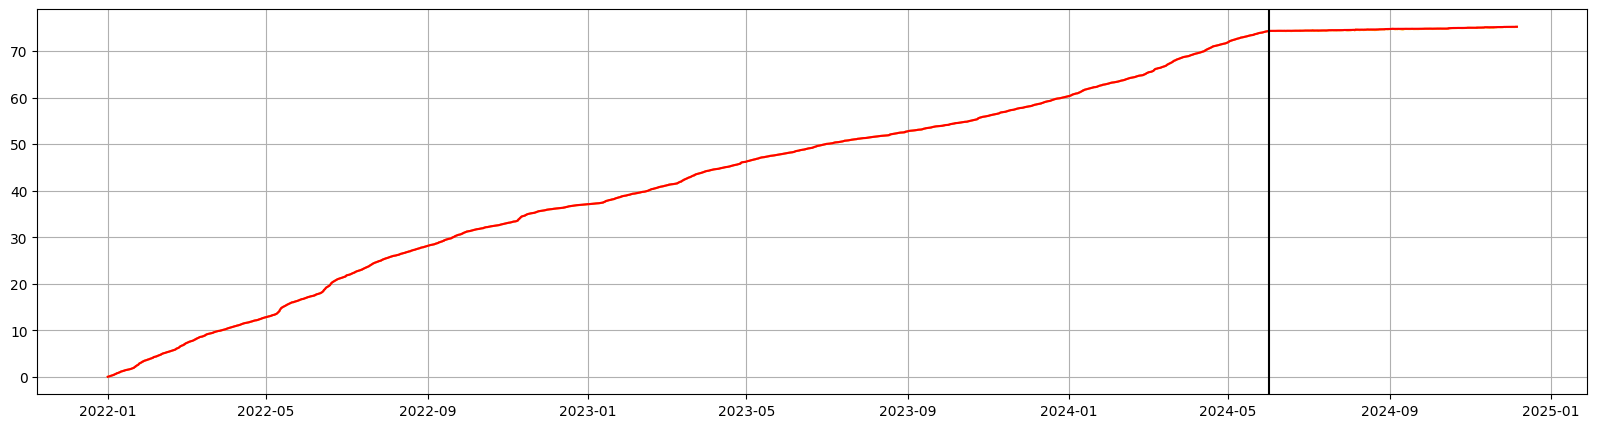

In [16]:
sharpe = func_model_performance(df)
func_plot(df)

In [14]:
import optuna
from functools import partial

def objective(trial, testDate=testDate, df=df):

  #length_rsi = int(trial.suggest_categorical("length_rsi",["6","12","18","24","30","36"]))
  #length_pvt = int(trial.suggest_categorical("length_pvt",["6","12","18","24","30","36"]))
  model_type = trial.suggest_categorical("model_type",["lr","dt","lr_reg","lr_cor","lr_rfe","elnet","lr_ig","cb"])

  df = func_features(df)
  df = func_train_model(model_type,df,testDate)
  sharpe = func_model_performance(df)

  return sharpe

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials = 20, timeout = 1000, show_progress_bar = True)

c:\Users\Mirom\Desktop\ML\ml-finance\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-12-06 13:44:46,990] A new study created in memory with name: no-name-deb1b855-4e1a-4b1e-a88f-4d29747867a9
Best trial: 0. Best value: 2.55459:   5%|▌         | 1/20 [00:07<02:27,  7.75s/it, 7.75/1000 seconds]

            train     test
PNL      : 2.212874   0.357988  
MDD      : 0.866233   0.289382  
Sharpe      : 2.554594   1.237078  
[I 2024-12-06 13:44:54,736] Trial 0 finished with value: 2.554594 and parameters: {'model_type': 'lr_rfe'}. Best is trial 0 with value: 2.554594.


Best trial: 1. Best value: 26.6083:  10%|█         | 2/20 [00:09<01:15,  4.20s/it, 9.46/1000 seconds]

            train     test
PNL      : 5.910132   0.354612  
MDD      : 0.222116   0.277496  
Sharpe      : 26.608313  1.2779    
[I 2024-12-06 13:44:56,450] Trial 1 finished with value: 26.608313 and parameters: {'model_type': 'lr'}. Best is trial 1 with value: 26.608313.


Best trial: 1. Best value: 26.6083:  15%|█▌        | 3/20 [00:17<01:44,  6.15s/it, 17.93/1000 seconds]

            train     test
PNL      : 2.212874   0.357988  
MDD      : 0.866233   0.289382  
Sharpe      : 2.554594   1.237078  
[I 2024-12-06 13:45:04,918] Trial 2 finished with value: 2.554594 and parameters: {'model_type': 'lr_rfe'}. Best is trial 1 with value: 26.608313.


Best trial: 1. Best value: 26.6083:  20%|██        | 4/20 [02:21<13:57, 52.32s/it, 141.02/1000 seconds]

            train     test
PNL      : 0.727819   0.436628  
MDD      : 0.978131   0.344047  
Sharpe      : 0.744092   1.269094  
[I 2024-12-06 13:47:08,009] Trial 3 finished with value: 0.744092 and parameters: {'model_type': 'elnet'}. Best is trial 1 with value: 26.608313.


Best trial: 1. Best value: 26.6083:  25%|██▌       | 5/20 [02:21<08:26, 33.74s/it, 141.80/1000 seconds]

            train     test
PNL      : 1.665595   0.408227  
MDD      : 0.485765   0.313659  
Sharpe      : 3.428808   1.301499  
[I 2024-12-06 13:47:08,796] Trial 4 finished with value: 3.428808 and parameters: {'model_type': 'dt'}. Best is trial 1 with value: 26.608313.


Best trial: 5. Best value: 28.0222:  30%|███       | 6/20 [02:22<05:14, 22.43s/it, 142.30/1000 seconds]

            train     test
PNL      : 6.374518   -0.013078 
MDD      : 0.227481   0.472518  
Sharpe      : 28.0222    -0.027677 
[I 2024-12-06 13:47:09,281] Trial 5 finished with value: 28.0222 and parameters: {'model_type': 'lr_reg'}. Best is trial 5 with value: 28.0222.


Best trial: 5. Best value: 28.0222:  35%|███▌      | 7/20 [02:22<03:18, 15.26s/it, 142.80/1000 seconds]

            train     test
PNL      : 6.374518   -0.013078 
MDD      : 0.227481   0.472518  
Sharpe      : 28.0222    -0.027677 
[I 2024-12-06 13:47:09,798] Trial 6 finished with value: 28.0222 and parameters: {'model_type': 'lr_reg'}. Best is trial 5 with value: 28.0222.


Best trial: 5. Best value: 28.0222:  40%|████      | 8/20 [04:44<11:05, 55.45s/it, 284.29/1000 seconds]

            train     test
PNL      : 0.727819   0.436628  
MDD      : 0.978131   0.344047  
Sharpe      : 0.744092   1.269094  
[I 2024-12-06 13:49:31,275] Trial 7 finished with value: 0.744092 and parameters: {'model_type': 'elnet'}. Best is trial 5 with value: 28.0222.


Best trial: 5. Best value: 28.0222:  45%|████▌     | 9/20 [04:44<07:01, 38.33s/it, 284.99/1000 seconds]

            train     test
PNL      : 1.665595   0.408227  
MDD      : 0.485765   0.313659  
Sharpe      : 3.428808   1.301499  
[I 2024-12-06 13:49:31,975] Trial 8 finished with value: 3.428808 and parameters: {'model_type': 'dt'}. Best is trial 5 with value: 28.0222.


Best trial: 5. Best value: 28.0222:  50%|█████     | 10/20 [05:02<05:18, 31.87s/it, 302.39/1000 seconds]

            train     test
PNL      : 2.212874   0.357988  
MDD      : 0.866233   0.289382  
Sharpe      : 2.554594   1.237078  
[I 2024-12-06 13:49:49,383] Trial 9 finished with value: 2.554594 and parameters: {'model_type': 'lr_rfe'}. Best is trial 5 with value: 28.0222.


Best trial: 5. Best value: 28.0222:  55%|█████▌    | 11/20 [05:02<03:20, 22.27s/it, 302.89/1000 seconds]

            train     test
PNL      : 6.374518   -0.013078 
MDD      : 0.227481   0.472518  
Sharpe      : 28.0222    -0.027677 
[I 2024-12-06 13:49:49,880] Trial 10 finished with value: 28.0222 and parameters: {'model_type': 'lr_reg'}. Best is trial 5 with value: 28.0222.


Best trial: 5. Best value: 28.0222:  60%|██████    | 12/20 [05:04<02:07, 15.99s/it, 304.51/1000 seconds]

            train     test
PNL      : 6.374518   -0.013078 
MDD      : 0.227481   0.472518  
Sharpe      : 28.0222    -0.027677 
[I 2024-12-06 13:49:51,498] Trial 11 finished with value: 28.0222 and parameters: {'model_type': 'lr_reg'}. Best is trial 5 with value: 28.0222.


Best trial: 5. Best value: 28.0222:  65%|██████▌   | 13/20 [05:06<01:21, 11.64s/it, 306.15/1000 seconds]

            train     test
PNL      : 6.374518   -0.013078 
MDD      : 0.227481   0.472518  
Sharpe      : 28.0222    -0.027677 
[I 2024-12-06 13:49:53,137] Trial 12 finished with value: 28.0222 and parameters: {'model_type': 'lr_reg'}. Best is trial 5 with value: 28.0222.


Best trial: 13. Best value: 25228.8:  70%|███████   | 14/20 [24:54<10:40, 106.73s/it, 1494.22/1000 seconds]

            train     test
PNL      : 74.374408  0.885843  
MDD      : 0.002948   0.159225  
Sharpe      : 25228.767978 5.563467  
[I 2024-12-06 14:09:41,201] Trial 13 finished with value: 25228.767978 and parameters: {'model_type': 'cb'}. Best is trial 13 with value: 25228.767978.


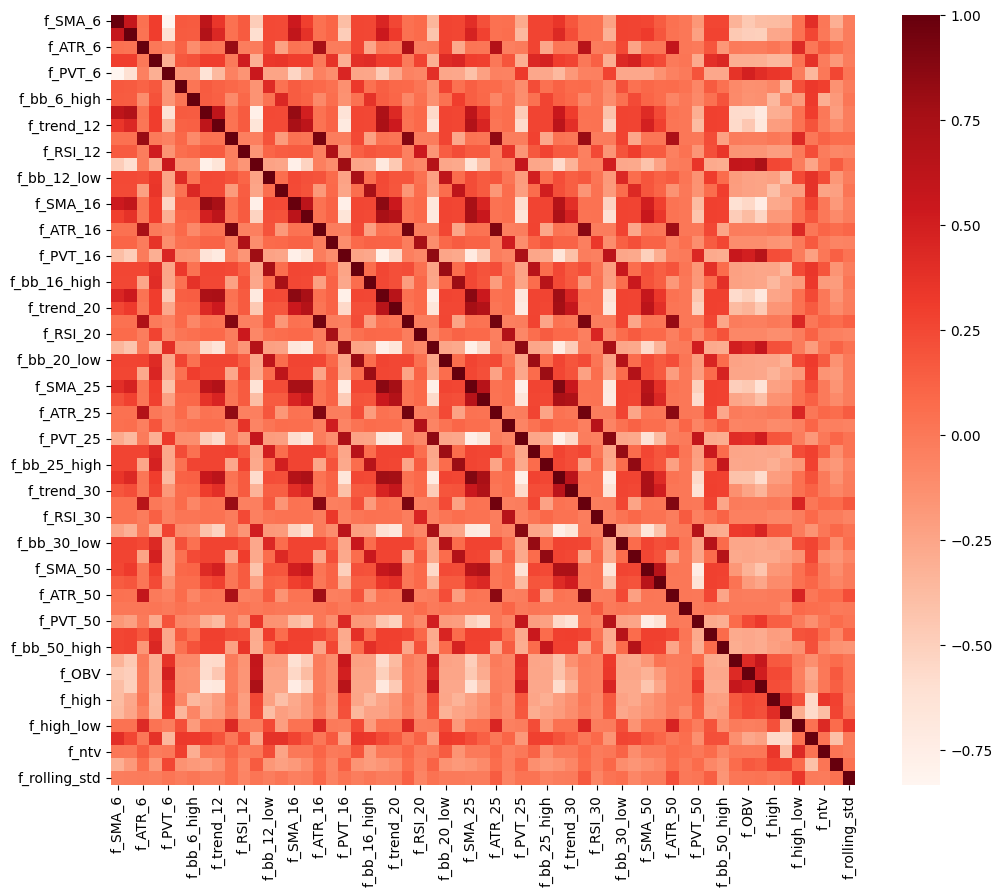

In [15]:
import seaborn as sns
features = [col for col in df if col.startswith('f_')]
plt.figure(figsize=(12,10))
cor = df[features].corr()
sns.heatmap(cor,annot=False, cmap=plt.cm.Reds)
plt.show()